In [1]:
import pandas as pd
import yaml
import numpy as np
import json
import requests
import collect_data
import re
from importlib import reload
from bs4 import BeautifulSoup
from contextlib import suppress
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
sns.set_style('darkgrid')
sns.set_palette('colorblind')
sns.set_color_codes()
sns.set_context('talk')
warnings.filterwarnings('ignore')

# Collecting Data From the NIPS 2017 Schedule

NIPS 2017 includes canonical links the authors' repository for a given paper.  We use BeautiulSoup to scrape the website's schedule metadata for paper information and the link to the repository.

**NOTE**: To collect data, an internet connection is required. Optionally, one can update the GitHub data with a API token. Pulling new data may result in different statistics from data collection at the time of publication.

In [2]:
soup = BeautifulSoup(requests.get("https://nips.cc/Conferences/2017/Schedule").content, 'html5lib')

In [3]:
poster_tables = soup.find_all('div', {'class':'maincard narrower Poster'})

In [4]:
papers = pd.DataFrame(index=range(len(poster_tables)),
                      columns=['title', 'authors', 'paper_url', 'code_url', 'poster_url'])

In [5]:
for p in papers.index:
    title = poster_tables[p].find('div',{'class':'maincardBody'}).contents[0]
    authors = poster_tables[p].find('div',{'class':'maincardFooter'}).contents[0]
    pdf = collect_data.get_url(poster_tables[p], 'Paper')
    repo = collect_data.get_url(poster_tables[p], 'Code')
    poster_pdf = collect_data.get_url(poster_tables[p], 'Poster')
    papers.loc[p] = pd.Series(dict(zip(papers.columns,
                                       [title, authors, pdf, repo, poster_pdf])))

In [6]:
papers.to_csv('all_papers.csv')

In [7]:
code_papers = papers[papers['code_url'].notnull()]

We also test the urls for GitHub repos by making a request to the listed webpage

In [8]:
code_papers['github'] = code_papers['code_url'].str.contains("github.com")

In [9]:
code_papers['live'] = [collect_data.test_url(url) for url in code_papers['code_url']]
code_papers['missing_http'] = np.logical_and(code_papers['live'], code_papers.code_url.str[:4] != 'http')
code_papers['code_url'] = ['http://' + code_papers['code_url'].ix[c] if code_papers['missing_http'].ix[c] else code_papers['code_url'].ix[c] for c in code_papers.index]
code_papers['gh_full_path'] = np.logical_and(code_papers['github'], 
                                             code_papers['code_url'].str.rstrip('/')\
                                             .str.split('/').str.len() > 4)

Some papers are not live at the time of testing, so we extract these and manually review to find the webpage

In [10]:
code_papers[np.logical_or(code_papers['live'] != True, ~code_papers['gh_full_path'])].to_csv('validate_url.csv')

In [11]:
live_gh = code_papers[np.logical_and(code_papers['gh_full_path'], code_papers['live'] == True)]

We collect scraped data on the existence of files in each repo that can be used by repo2docker by inspecting the GitHub page of each repo for the file.  The file types are listed in `file_types`.

GitHub metadata is collected using the GitHub graphql api.  To run this query, one will need to create a [personal access token with GitHub](https://help.github.com/articles/creating-a-personal-access-token-for-the-command-line/).

The block of code below collects all the data from GitHub. Again, this does not run except with a personal access token. Repo2docker file information from this block is saved as `gh_r2d_data.csv`, and GitHub metadata is saved as `gh_metadata.csv`.  Note also we exclude repositories that have changed their URL and include in later analysis.

We have supressed these exceptions to get the notebook to run the whole way through

In [12]:
file_types = ['Dockerfile', 'binder', 'apt.txt', 'environment.yml',
          'requirements.txt', 'postBuild', 'setup.py', 'REQUIRE', 'runtime.txt',
          'install.R']
social_vals = ['description', 'stargazers', 'watchers',
           'forks', 'languages', 'repositoryTopics'] 
r2d_checks = pd.DataFrame(index=live_gh['code_url'], columns=file_types)
with suppress(Exception):
    for i in r2d_checks.index:
        gh_url = re.sub(r"\.git$", "", i)
        soup_i = BeautifulSoup(requests.get(gh_url).content, "html5lib")
        r2d_checks.loc[i] = pd.Series(collect_data.request_inspect_for_r2d(i, soup_i, file_types))
r2d_checks.to_csv('gh_r2d_data.csv')

To recollect data, you will need to replace the line below with your GitHub personal access token
For ease of processing, we strip `.git` extensions to standardize our data collection.

In [13]:
try:
    credentials = yaml.load(open('../binder_study/secrets.yml'))  
    gh_metadata = pd.DataFrame(index=live_gh['code_url'], columns=social_vals)
    with suppress(Exception):
        for i in gh_metadata.index:
            gh_url = re.sub(r"\.git$", "", i)
            split_url = gh_url.split('/')
            gh_metadata.loc[i] = pd.Series(collect_data.graphql_social_data(split_url[3],
                                    split_url[4], credentials['binder']['key']))
    live_gh[live_gh['code_url'].isin(gh_metadata[gh_metadata.isna().all(axis=1)]\
                                     .index.values)].to_csv('change_reponame.csv')
    gh_metadata = collect_data.process_gh_api_df(gh_metadata.dropna(how='all'))
    gh_metadata[gh_metadata['no_code']].to_csv('no_code.csv')
    gh_metadata = gh_metadata[~gh_metadata['no_code']] 
    gh_metadata.to_csv('gh_metadata.csv')
except:
    gh_metadata = pd.read_csv('gh_metadata.csv', index_col=0)                                

We drop data that does not have any programming languages associated with the repo.

In [14]:
r2d_checks = r2d_checks[r2d_checks.index.isin((~gh_metadata['no_code']).index)]
r2d_checks.to_csv('gh_r2d_data.csv')

## Analyzing Manually Annotated Data

For repositories that do not have automatically accessible repositories available, we manually annotate to find the author's URL. Files with these lables are loaded below.

In [15]:
gh_labeled = pd.read_csv('validate_url_w_labels.csv', index_col=0)
changed_url_labeled = pd.read_csv('change_reponame_labeled.csv', index_col=0)

In [16]:
r2d_labeled = pd.DataFrame(index=gh_labeled[gh_labeled['labeled_url'].str[:19] == 'https://github.com/']
                           ['labeled_url'].append(changed_url_labeled['labeled_url']), columns=file_types)

In [17]:
gh_metadata_labeled = pd.DataFrame(index=r2d_labeled.index, columns=social_vals)

We now collect data for these labeled URLs using the same methodology to find configuration files and GitHub metadata. Again, an access token can be used to pull the latest GitHub data.

In [18]:
with suppress(Exception):
    for i in r2d_labeled.index:
        split_url = i.split('/')
        soup_i = BeautifulSoup(requests.get(i).content, "html5lib")
        if i not in r2d_checks.index:
            r2d_labeled.loc[i] = pd.Series(collect_data.request_inspect_for_r2d(i, soup_i, file_types))
try:
    r2d_labeled.to_csv('r2d_labeled.csv')
except:
    r2d_labeled = pd.read_csv('r2d_labeled.csv')

In [19]:
try:
    for i in gh_metadata_labeled.index:
        split_url = i.split('/')
        gh_metadata_labeled.loc[i] = pd.Series(collect_data.graphql_social_data(split_url[3], split_url[4], credentials['binder']['key']))
    gh_metadata_labeled = collect_data.process_gh_api_df(gh_metadata_labeled)
    gh_metadata_labeled.to_csv('gh_labeled.csv')
except:
    gh_metadata_labeled = pd.read_csv('gh_labeled.csv', index_col=0)

Labeled and unlabeled datasets are combined below.

In [20]:
try:
    total_gh_metadata = pd.concat([gh_metadata, gh_metadata_labeled])
    total_r2d = pd.concat([r2d_checks, r2d_labeled])
    total_gh_metadata.to_csv('gh_metadata_w_labeled.csv')
    total_r2d.to_csv('r2d_w_labeled.csv')
except:
    total_gh_metadata = pd.read_csv('gh_metadata_w_labeled.csv', index_col=0)
    total_r2d = pd.read_csv('r2d_w_labeled.csv', index_col=0)

# Conference Wide Metrics

We calculate the percent of papers that have included any code url, a paper url, and a url to a live GitHub page.

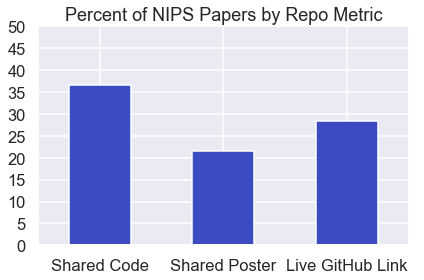

In [21]:
paper_metrics = (len(papers) - papers.isnull().sum()).loc[['code_url','poster_url']]\
.append(live_gh[['gh_full_path']].sum())
paper_metrics.index = ['Shared Code', 'Shared Poster', 'Live GitHub Link']
(100.*paper_metrics/len(papers)).plot(kind='bar', cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('Percent of NIPS Papers by Repo Metric')
plt.yticks(np.arange(0,55,5))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('paper_metrics.pdf')

Below are the raw counts:

In [22]:
paper_metrics

Shared Code         248
Shared Poster       146
Live GitHub Link    193
dtype: int64

Below are the percentages in the above plot.

In [23]:
(100.*paper_metrics/len(papers))

Shared Code         36.524300
Shared Poster       21.502209
Live GitHub Link    28.424153
dtype: float64

Programming languages that repo2docker supports are popular among NIPS authors

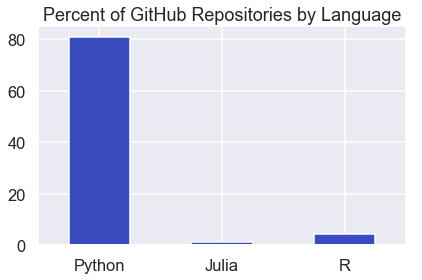

In [24]:
(100*total_gh_metadata[['Python', 'Julia', 'R']].sum()/len(total_gh_metadata)).plot(kind='bar', cmap='coolwarm')
plt.title('Percent of GitHub Repositories by Language')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('pct_languages.pdf')

We plot the primary languages of the repositories. By far, the most popular language is Python.

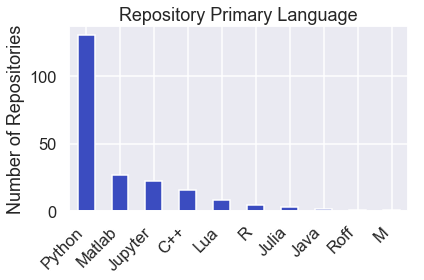

In [25]:
primary_languages= total_gh_metadata['primary_language'].value_counts()
primary_languages.rename(index={'Jupyter Notebook': 'Jupyter'}, inplace=True)
primary_languages.plot(kind='bar', cmap='coolwarm')
plt.title('Repository Primary Language')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.savefig('primary_language.pdf')

For reference, we also include information on papers that were manually labeled.  A minority of them required manual review.

In [26]:
labeled_url_stats = gh_labeled['labeled_url'].notnull().value_counts()
labeled_url_stats.index = ['found url', 'url still missing']
labeled_url_stats.loc['changed_url'] = len(changed_url_labeled)
labeled_url_stats.index = ['found url', 'url still missing', 'changed url']

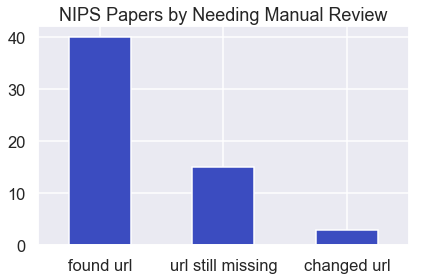

In [27]:
labeled_url_stats.plot(kind='bar',  cmap='coolwarm')
plt.ylabel('')
plt.xlabel('')
plt.title('NIPS Papers by Needing Manual Review')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('manual_review_metrics.pdf')

In [28]:
len(papers)

679

# Reproducing Reults Figures

For reference there are 197 papers in our analysis

In [29]:
len(total_gh_metadata)

215

We first plot the number of repositories by each type of configuration file

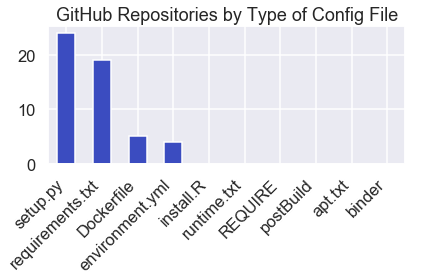

In [30]:
total_r2d.sum().sort_values(ascending=False).plot(kind='bar', colormap='coolwarm')
plt.title('GitHub Repositories by Type of Config File')
plt.ylabel('')
plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.savefig('repos_by_r2d_file.pdf')

Below are the raw values:

In [31]:
total_r2d.sum().sort_values(ascending=False)

setup.py            24
requirements.txt    19
Dockerfile           5
environment.yml      4
install.R            0
runtime.txt          0
REQUIRE              0
postBuild            0
apt.txt              0
binder               0
dtype: int64

Below are the number of repositories that have 0, 1, 2, or 3 configuration files:

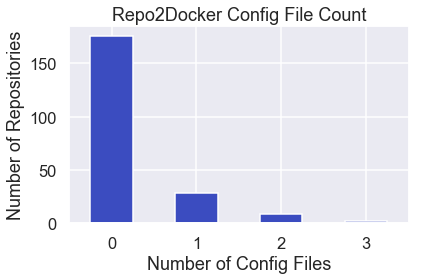

In [32]:
total_r2d.sum(axis=1).value_counts().plot(kind='bar', colormap='coolwarm', rot=0)
plt.xlabel('Number of Config Files')
plt.ylabel('Number of Repositories')
plt.title('Repo2Docker Config File Count')
plt.tight_layout()
plt.savefig('total_r2d_files_plot.pdf')

The raw values of the plot above are below

In [33]:
total_r2d.sum(axis=1).value_counts()

0    176
1     28
2      9
3      2
dtype: int64

We now label repositories that are repo2docker compatible as repositories that have at least 1 type of configuration file that repo2docker uses.

In [34]:
total_gh_metadata['r2d_capable'] = total_r2d.sum(axis=1) > 0

The average number of users that have forked, starred, or watched is significantly higher when we exclude repositories that are part of larger libraries.  We label larger libraries as libraries that point to a specific folder in the repo as the code, rather than the main repository URL.  These libraries are part of larger deep learning repos.

In [70]:
total_gh_metadata['main_repo'] = np.logical_or(total_gh_metadata.index.str.rstrip('/').str.split('/').str.len() < 6, 
np.logical_and(total_gh_metadata.index.str.rstrip('/').str.split('/').str.len() == 7, total_gh_metadata.index.str.rstrip('/').str.split('/').str[5] == 'tree'))
main_repo = total_gh_metadata[total_gh_metadata['main_repo']]
wo_larger_test = ttest_ind(main_repo[main_repo['r2d_capable']][['forks', 'stargazers', 'watchers']],
          main_repo[~main_repo['r2d_capable']][['forks', 'stargazers', 'watchers']])

In [71]:
wo_larger_test

Ttest_indResult(statistic=array([2.15421431, 2.49946935, 2.54987436]), pvalue=array([0.03236211, 0.01320364, 0.01148913]))

The means of these two groups are listed below:

In [72]:
gh_means = main_repo.groupby('r2d_capable')[['forks', 'stargazers', 'watchers']].mean()

In [73]:
gh_means

,forks,stargazers,watchers
r2d_capable,,,
False,28.150289,108.947977,9.387283
True,95.358974,411.846154,29.897436


Also, the percent difference between repos with and without these configuration files

In [77]:
(gh_means.loc[True] - gh_means.loc[False])/gh_means.loc[False]

forks         2.387495
stargazers    2.780209
watchers      2.184887
dtype: float64

We also plot the means with errorbars when excluding larger libraries

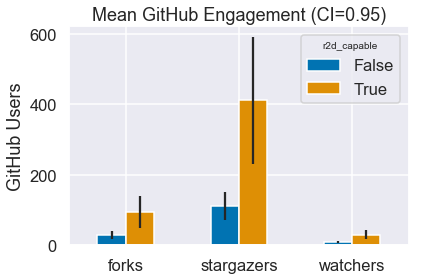

In [78]:
r2d_gh_groupby = total_gh_metadata[~total_gh_metadata['larger_library']].groupby(['r2d_capable'])[['forks', 'stargazers', 'watchers']]
r2d_gh_groupby.mean().T.plot(kind='bar', yerr=.975*r2d_gh_groupby.sem().T)
plt.xlabel('')
plt.ylabel('GitHub Users')
plt.title('Mean GitHub Engagement (CI=0.95)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('engagement_excl_lrg.pdf')

Below is the number of repositories in each category. `r2d_capable` means the repo has at least 1 config file used by repo2docker.

In [79]:
main_repo.groupby('r2d_capable')['stargazers'].count()

r2d_capable
False    173
True      39
Name: stargazers, dtype: int64

Below are the larger libraries we've excluded from our analysis

In [82]:
larger_libraries = total_gh_metadata[~total_gh_metadata['main_repo']]
larger_libraries.to_csv('larger_libraries.csv')

In [83]:
larger_libraries

,description,stargazers,watchers,forks,languages,repositoryTopics,n_languages,no_code,primary_language,Python,Julia,R,r2d_capable,larger_library,main_repo
https://github.com/tensorflow/models/tree/master/research/pcl_rl,Models and examples built with TensorFlow,41047,2562,22816,"[Python, Jupyter Notebook, C++, HTML, Shell, J...",[],9,False,Python,True,False,False,False,True,False
https://github.com/tensorflow/models/tree/master/research/rebar,Models and examples built with TensorFlow,41047,2562,22816,"[Python, Jupyter Notebook, C++, HTML, Shell, J...",[],9,False,Python,True,False,False,False,True,False
https://github.com/tensorflow/models/tree/master/research/fivo,Models and examples built with TensorFlow,41047,2562,22816,"[Python, Jupyter Notebook, C++, HTML, Shell, J...",[],9,False,Python,True,False,False,False,True,False


For simplicity, we also plot a boxplot to highlight these outliers.

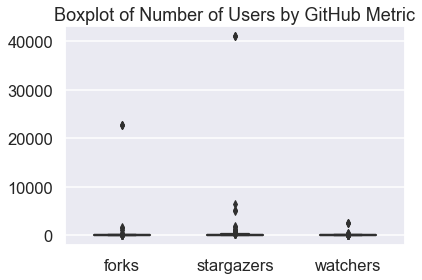

In [84]:
sns.boxplot(data=total_gh_metadata[['forks', 'stargazers', 'watchers']], fliersize=5, width=.5)
plt.title('Boxplot of Number of Users by GitHub Metric')
plt.tight_layout()
plt.savefig('gh_metrics_boxplot.pdf')